# Petfinder Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## Project Details
* **Problem**: I plan to look at a snapshot of adoptable dogs across the United States (as posted on [Petfinder.com](https://www.petfinder.com)) to determine the regional differences in the average length of time that a posting remains on Petfinder, based on the US state where it was posted. We will also briefly look at the distribution of what dog breeds are reported in shelters/rescues across the US. In particular, I want to look at this distribution state-by-state (including DC).
* **Questions**:
    - What is the current average length of stay (LOS) for dogs in each state?
        - Is the average LOS significantly different for each state?
    - For each state (+ DC), what is the most populous reported breed found in shelters?
        - For each US state (+ DC), what are the top 10 reported breeds?
* **Justification**: It is clear from [research](https://www.tandfonline.com/doi/abs/10.1080/10888705.2013.740967) that there are various factors that may influence a dog's adoptability, including the dog's physical appearance, breed, and behavior. However, the circumstances of the individual shelter or rescue organization should also be considered. Some shelters may have better publicity, funding, and resources that lead to greater adoption rates. This analysis will explore how the US state where the shelter/rescue is based may influence the amount of time a dog remains up for adoption. Additionally, it will examine the distribution of dog breeds across dates. Examining which reported dog breeds are most often ending up homeless and offered for adoption in local shelters/rescues may help to answer questions about breed popularity and dog ownership culture in the United States (and whether there are any region-specific trends). It may also help to answer questions about how meaningful a breed identity actually is in the context of animal rescue. [This professional study](https://pubmed.ncbi.nlm.nih.gov/27008213/) determined that breed labels in dogs can influence their perceived adoptability and LOS. Hopefully, this analysis will provide some insight into how dog breed identity in shelter/rescue systems differs by region. The results could perhaps lead to further study or reinforce preexisting conclusions.
* **Datasets**: [allDogDescriptions.csv](https://github.com/the-pudding/data/tree/master/dog-shelters), a dataset of all adoptable dogs from Petfinder.com on September 20th, 2019.
* **Ethical Concerns/Considerations**:
    - The data has the potential to inspire biases associated with certain organizations or US regions.
    - The results may cause people to draw false conclusions about why certain breeds often end up in shelters and rescues.
    - The results risk reinforcing biases associated with various dog breeds.
    - The results may influence rescue/shelter intake depending on the dog's perceived adoptability.

The first task is to simply read in the data.

In [3]:
df = pd.read_csv("data/allDogDescriptions.csv")
to_drop = df[ (df['contact_state'] == 'NB') | (df['contact_state'] == 'QC')].index
df.drop(to_drop, inplace = True)
df.head()

,id,org_id,url,type.x,species,breed_primary,breed_secondary,breed_mixed,breed_unknown,color_primary,...,status,posted,contact_city,contact_state,contact_zip,contact_country,stateQ,accessed,type.y,description
0,46042150,NV163,https://www.petfinder.com/dog/harley-46042150/...,Dog,Dog,American Staffordshire Terrier,Mixed Breed,True,False,White / Cream,...,adoptable,2019-09-20T16:37:59+0000,Las Vegas,NV,89147,US,89009,2019-09-20,Dog,Harley is not sure how he wound up at shelter ...
1,46042002,NV163,https://www.petfinder.com/dog/biggie-46042002/...,Dog,Dog,Pit Bull Terrier,Mixed Breed,True,False,Brown / Chocolate,...,adoptable,2019-09-20T16:24:57+0000,Las Vegas,NV,89147,US,89009,2019-09-20,Dog,6 year old Biggie has lost his home and really...
2,46040898,NV99,https://www.petfinder.com/dog/ziggy-46040898/n...,Dog,Dog,Shepherd,NaN,False,False,Brindle,...,adoptable,2019-09-20T14:10:11+0000,Mesquite,NV,89027,US,89009,2019-09-20,Dog,Approx 2 years old.\n Did I catch your eye? I ...
3,46039877,NV202,https://www.petfinder.com/dog/gypsy-46039877/n...,Dog,Dog,German Shepherd Dog,NaN,False,False,NaN,...,adoptable,2019-09-20T10:08:22+0000,Pahrump,NV,89048,US,89009,2019-09-20,Dog,NaN
4,46039306,NV184,https://www.petfinder.com/dog/theo-46039306/nv...,Dog,Dog,Dachshund,NaN,False,False,NaN,...,adoptable,2019-09-20T06:48:30+0000,Henderson,NV,89052,US,89009,2019-09-20,Dog,Theo is a friendly dachshund mix who gets alon...


First, we can simply view the overall frequencies of identified dog breeds admitted into rescues and shelters on Petfinder:

In [5]:
print("OVERALL FREQUENCIES FOR PRIMARY LISTED BREED:")
print(df['breed_primary'].value_counts())
print("\n\nOVERALL FREQUENCIES FOR SECONDARY LISTED BREED:")
print(df['breed_secondary'].value_counts())
uniq_breeds = pd.concat([df['breed_primary'], df['breed_secondary']]).drop_duplicates()
print("\n\nNUMBER OF UNIQUE DOG BREEDS: ", uniq_breeds.size)

OVERALL FREQUENCIES FOR PRIMARY LISTED BREED:
Pit Bull Terrier        7889
Labrador Retriever      7197
Chihuahua               3766
Mixed Breed             3242
Terrier                 2641
                        ... 
Skye Terrier               1
Old English Sheepdog       1
Briard                     1
Field Spaniel              1
Fila Brasileiro            1
Name: breed_primary, Length: 216, dtype: int64


OVERALL FREQUENCIES FOR SECONDARY LISTED BREED:
Mixed Breed               4347
Labrador Retriever        2194
Pit Bull Terrier          1365
Terrier                   1195
Hound                     1143
                          ... 
Japanese Chin                1
English Cocker Spaniel       1
Portuguese Water Dog         1
German Pinscher              1
American Water Spaniel       1
Name: breed_secondary, Length: 190, dtype: int64


NUMBER OF UNIQUE DOG BREEDS:  223


The most common dog listed as the primary breed is the Pit Bull Terrier, closely followed by the Labrador Retriever and then by the Chihuahua. The most common secondary breed is simply "Mixed Breed", followed again by the lab and the pit bull. In total, there are 223 unique breeds posted on Petfinder.

**Question**: For each state (+ DC), what is the most populous reported breed found in shelters? Top 10?

In [28]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# tail is to omit erroneous data
df.groupby('contact_state')['breed_primary'].value_counts().groupby('contact_state').apply(lambda x : x.nlargest(10)).tail(-30)

contact_state  contact_state  breed_primary                      
AK             AK             Husky                                    8
                              German Shepherd Dog                      6
                              Dachshund                                1
AL             AL             Labrador Retriever                     255
                              Pit Bull Terrier                       168
                              Terrier                                134
                              Hound                                   72
                              Chihuahua                               68
                              Shepherd                                65
                              American Bulldog                        58
                              Boxer                                   56
                              German Shepherd Dog                     55
                              Retriever                   

**Question**: What is the current average length of stay (LOS) for dogs in each state?
<br>This refers only to pets who are still listed on Petfinder, where we "guess" the length of stay by comparing the date the dog was posted to the date the data was collected. I will take the average LOS for each U.S. state. Units are in days.

In [30]:
"""
Consumes two strings representing a date/time
Returns the number of days between the two dates.
"""
def subdate(date1, date2):
    # YYYY-MM-DD
    if '-' not in date2 or 'T' not in date2:
        return
    date2 = date2[0:date2.index('T')]
    date1 = pd.to_datetime(date1)
    date2 = pd.to_datetime(date2)
    return (date1 - date2).days


losDF = df.copy(deep=True)
losDF['los'] = df['posted'].apply(lambda x : subdate('2019-09-20', str(x)))
state_los = losDF.groupby('contact_state')['los'].mean().dropna()
state_los

contact_state
AK     82.600000
AL    203.932073
AR    147.164029
AZ    276.432829
CA    215.117788
CO    113.051889
CT    147.968354
DC     76.428571
DE     99.131757
FL    151.836781
GA    194.608508
HI     22.652174
IA    115.886598
ID     55.775510
IL    284.228007
IN    203.675546
KS    167.017021
KY    163.202137
LA    467.381579
MA     98.003171
MD    232.185532
ME    119.500917
MI    137.643388
MN     89.295407
MO    201.551087
MS    439.366667
MT     15.555556
NC    177.469357
ND    244.453125
NE     63.858333
NH     95.665672
NJ    201.373263
NM     86.408805
NV    302.449242
NY    234.235882
OH    175.885393
OK    313.008557
OR    124.197802
PA    187.778802
RI     69.884679
SC    237.458591
SD     73.541667
TN    197.043527
TX    219.747350
UT     95.608247
VA    204.867233
VT    116.988235
WA    108.893500
WI    100.704797
WV    230.672566
WY     70.115385
Name: los, dtype: float64

To better understand the data, let's visualize it as a bar graph. We will first take the average (mean) number of days for each state.

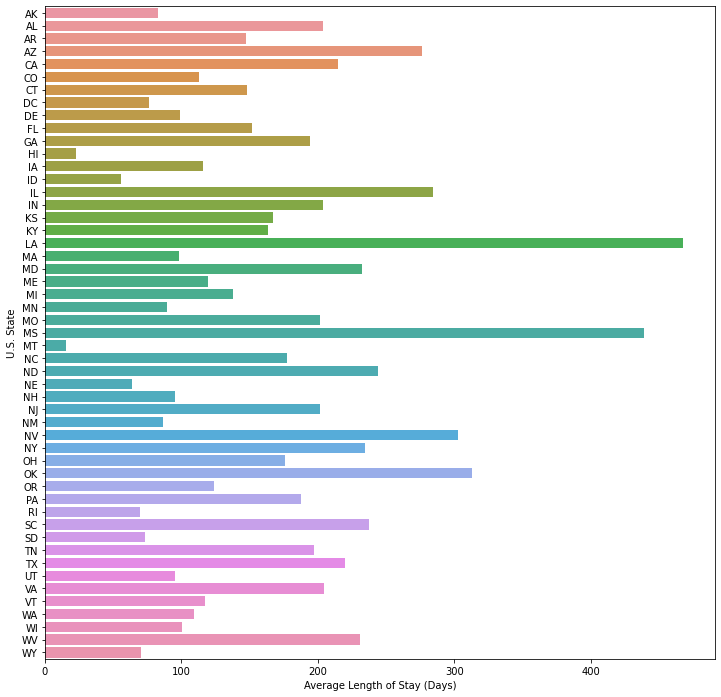

In [31]:
state_los = pd.DataFrame(state_los)
figure = plt.gcf()
figure.set_size_inches(12, 12)

sns.barplot(x = 'los', y = state_los.index, data = state_los)
plt.xlabel('Average Length of Stay (Days)')
plt.ylabel('U.S. State')
plt.show()

There may be outliers, so I'd like to repeat this process using the median instead of the mean.

In [32]:
state_los_2 = losDF.groupby('contact_state')['los'].median().dropna()
state_los_2

contact_state
AK     50.0
AL     36.0
AR     42.0
AZ     43.0
CA     25.0
CO     27.0
CT     32.0
DC     19.5
DE     23.0
FL     37.0
GA     43.0
HI     10.0
IA     38.0
ID     22.0
IL     51.5
IN     37.0
KS     37.0
KY     32.0
LA     86.5
MA     24.0
MD     43.0
ME     23.0
MI     31.0
MN     23.0
MO     58.0
MS     49.5
MT     10.0
NC     33.0
ND     51.5
NE     20.0
NH     25.0
NJ     48.0
NM     26.0
NV     30.0
NY     57.0
OH     38.0
OK    126.0
OR     17.0
PA     41.0
RI     20.0
SC     38.0
SD     14.5
TN     36.0
TX     38.0
UT     44.0
VA     42.0
VT     40.0
WA     28.0
WI     17.0
WV     65.0
WY     33.5
Name: los, dtype: float64

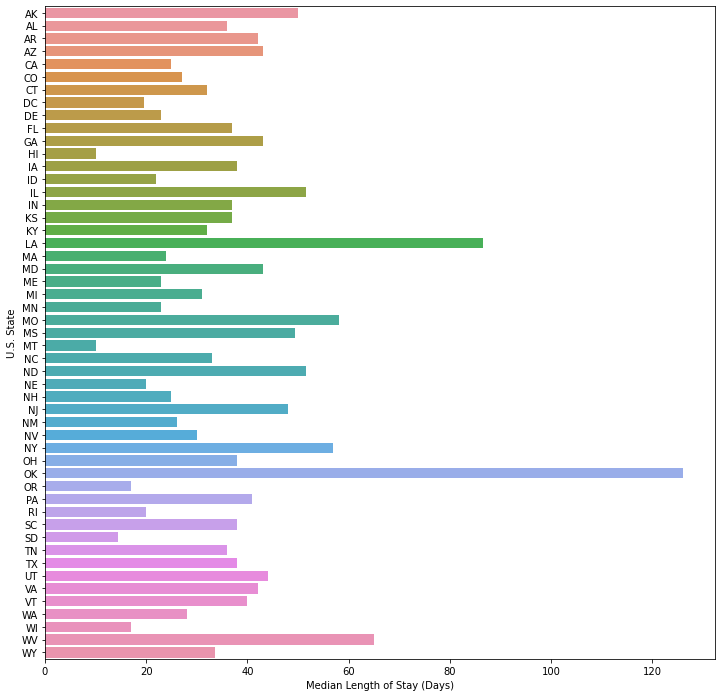

In [33]:
state_los_2 = pd.DataFrame(state_los_2)
figure = plt.gcf()
figure.set_size_inches(12, 12)

sns.barplot(x = 'los', y = state_los_2.index, data = state_los_2)
plt.xlabel('Median Length of Stay (Days)')
plt.ylabel('U.S. State')
plt.show()

Is the data normally distributed?

In [34]:
test_statistic, p_value = stats.shapiro(state_los['los'])
if p_value < 0.05:
    print("Since the pvalue is less than 0.05, we reject the null hypothesis that the mean LOS values are normally distributed.\n")
else:
    print("Since the pvalue is greater than 0.05, we accept the null hypothesis that the mean LOS values are normally distributed.\n")

test_statistic, p_value = stats.shapiro(state_los_2['los'])
if p_value < 0.05:
    print("Since the pvalue is less than 0.05, we reject the null hypothesis that the median LOS values are normally distributed.")
else:
    print("Since the pvalue is greater than 0.05, we accept the null hypothesis that the median LOS values are normally distributed.")

Since the pvalue is less than 0.05, we reject the null hypothesis that the mean LOS values are normally distributed.

Since the pvalue is less than 0.05, we reject the null hypothesis that the median LOS values are normally distributed.


So far, the data is not normally distributed in either case. We will log transform both distributions and plot them again for readability. Then, we will see if they follow a normal distribution.

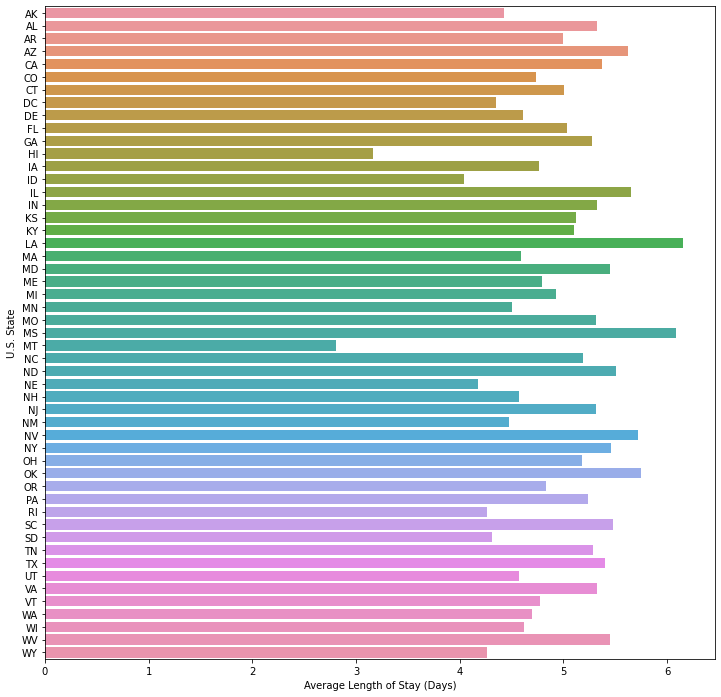

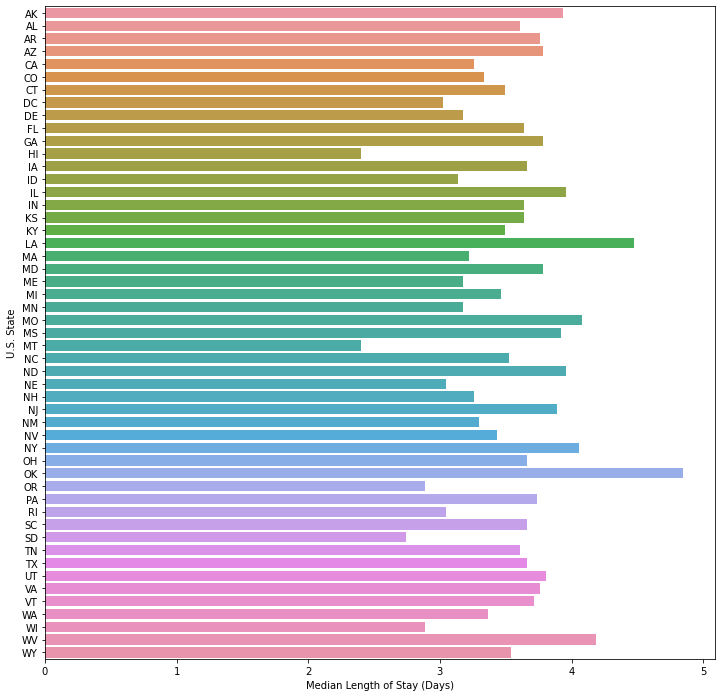

In [35]:
transformed1 = state_los['los']
transformed1 = transformed1.apply(np.log1p)
transformed2 = state_los_2['los']
transformed2 = transformed2.apply(np.log1p)

transplot1 = pd.DataFrame(transformed1)
transplot2 = pd.DataFrame(transformed2)

sns.barplot(x = 'los', y = transplot1.index, data = transplot1)
figure = plt.gcf()
figure.set_size_inches(12, 12)
plt.xlabel('Average Length of Stay (Days)')
plt.ylabel('U.S. State')
plt.show()
sns.barplot(x = 'los', y = transplot2.index, data = transplot2)
figure = plt.gcf()
figure.set_size_inches(12, 12)
plt.xlabel('Median Length of Stay (Days)')
plt.ylabel('U.S. State')
plt.show()

In [36]:
test_statistic, p_value = stats.shapiro(transformed1)
if p_value < 0.05:
    print("Since the pvalue is less than 0.05, we reject the null hypothesis that the transformed mean LOS values are normally distributed.\n")
else:
    print("Since the pvalue is greater than 0.05, we accept the null hypothesis that the transformed mean LOS values are normally distributed.\n")

test_statistic, p_value = stats.shapiro(transformed2)
if p_value < 0.05:
    print("Since the pvalue is less than 0.05, we reject the null hypothesis that the transformed median LOS values are normally distributed.")
else:
    print("Since the pvalue is greater than 0.05, we accept the null hypothesis that the transformed median LOS values are normally distributed.")

Since the pvalue is less than 0.05, we reject the null hypothesis that the transformed mean LOS values are normally distributed.

Since the pvalue is greater than 0.05, we accept the null hypothesis that the transformed median LOS values are normally distributed.


We have determined that the data is normal when we take the medians of the LOS values and then log transform them.

Let's perform the Krustakl-Walkkish H-test to determine if there is a statistically significant difference between medians.

In [37]:
losDF = losDF.dropna(subset=['los'])
args = losDF.groupby('contact_state')['los'].apply(pd.Series.tolist).tolist()
test_statistic, p_value = stats.kruskal(*args)

if p_value < 0.05:
    print("Since the pvalue is less than 0.05, we reject the null hypothesis that the medians are equal.")
else:
    print("Since the pvalue is greater than 0.05, we accept the null hypothesis that the medians are equal.")

Since the pvalue is less than 0.05, we reject the null hypothesis that the medians are equal.


From this, it appears that regional differences (based on median) in LOS are statistically significant. It may be worth pursuing these results further--getting to the root of why this might be, and which regions in particular differ the most. This may be due to a variety of factors, such as financial resources, local culture, population, etc. This data can be used to justify aid to local organizations to help bolster adoptions, thus shortening LOS.